In [1]:
import sys
import shapely
from shapely.geometry import box, MultiPolygon, LineString, Point, MultiLineString, Polygon
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from gridmap import OccupancyGridMap
import matplotlib.pyplot as plt
from a_star import a_star
from utils import plot_path
from sklearn import preprocessing
import pandas as pd
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split
import random
from tqdm import tqdm
import imageio

import warnings
warnings.filterwarnings('ignore')

In [78]:
num_points_on_circ = 360
pi = math.pi
def PointsInCircum(r,n=num_points_on_circ, center = (0,0)):
    return np.array([(center[0] + math.cos(2*pi/n*x)*r, center[1] + math.sin(2*pi/n*x)*r) for x in range(0,n+1)])

In [3]:
def gen_shapely_map(map_size, obstacles):
    '''
    Given map_size and list of obstacles where
    an obstacle is described by a tuple (xmin, ymin, xmax, ymax),
    create a shapely map. 
    '''
    
    pols = [box(0,0,map_size[0], map_size[1])]
    for obstacle in obstacles:
        pols.append(box(*obstacle))
    lines = []
    for pol in pols:
        boundary = pol.boundary
        if boundary.type == 'MultiLineString':
            for line in boundary:
                lines.append(line)
        else:
            lines.append(boundary)

    MAP = MultiLineString(lines)
    return MAP

def get_map_arr(MAP_params, shape):
    '''
    Convert the shapely obstacles into a numpy grid
    for use with the A* planner. 
    
    MAP_params is of the form [(xmin, ymin, xmax, ymax), (xmin, ymin, xmax, ymax), ...]
    describing each rectangular obstacle in the map. Currently only supports rectangles. 
    
    Shape is just a tuple with the map size. 
    
    '''
    map_np = np.zeros(shape)
    for param in MAP_params:
        xmin, ymin, xmax, ymax = param
        map_np[ymin:ymax, xmin:xmax] = 1
        
    return map_np

In [4]:
# Mapping from label encoder (just hard coded it here)
dirs = {0:(1.0, 0.0), 1:(0.0, 1.0), 2:(-1.0, 0.0), 3:(0.0, -1.0)}
inv_dirs = {d: label for label, d in dirs.items()}

In [26]:
# 4n = 4 point connectivity. 8N = 8 point connectivity
def synthetic_sensor(MAP, robot_location, direction, movement='4N'):
    '''
    Given a shapely map and the robots current location, 
    return the 360 degree laser scanner. 
    '''
    lines = []
    # 100 is arbitrary radius. Just needs to be big enough to draw line across map. 
    points = PointsInCircum(100, center = robot_location)
    # Create line to all points on circle
    for point in points:
        A = Point(robot_location)
        B = Point(point)
        line = LineString([A,B])
        lines.append(line)
    # Get points of intersection. 
    for i, line in enumerate(lines):

        # These two types of objects signify multiple intersections. 
        if type(MAP.intersection(line)) == shapely.geometry.multilinestring.MultiLineString or \
               type(MAP.intersection(line)) == shapely.geometry.multipoint.MultiPoint:
            # Get the closest point
            temp_dist = []
            for point in MAP.intersection(line):
#                 try:
                temp_dist.append(LineString([robot_location, point]).length)
            inter = MAP.intersection(line)[np.argmin(temp_dist)]
        # This signifies no intersection. Wont happen on current map. 
        elif type(MAP.intersection(line)) == shapely.geometry.collection.GeometryCollection:
            cp = MAP.intersection(line)[0] 
            lines[i].coords = [robot_location, cp]
            continue
        # One intersection
        else:
            inter = MAP.intersection(line)
        # Create new point and update end point in list of lines. 
        new_point = (inter.xy[0][0], inter.xy[1][0])
        lines[i].coords = [robot_location, new_point]
    
    # Get lase scan data (distances)
    distances = [line.length for line in lines][:num_points_on_circ]
    # Account for robot orientation
    if direction != (0, 0): # Start node
        if movement == '4N':
            offset = int(len(distances) / 4.) * inv_dirs[direction]
        else: 
            offset = int(len(distances) / 8.) * inv_dirs[direction]
        distances = distances[offset:] + distances[:offset]  
    return distances, lines
    

In [6]:
def plot(MAP, robot_location, line_strings = None, plot_lines=False):
    '''
    This plot function is used to show the laser scan lines. 
    Current not used. Probably will be helpful when creating visualizations. 
    '''
    fig = plt.figure(frameon=False)
    fig.set_size_inches(50,50)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    for index, l in enumerate(MAP): 
        if index != 0:
            ax.fill(*l.xy, alpha=1)
        else:
            ax.plot(*l.xy, alpha=1)
    if plot_lines:
        for line in line_strings:
            ax.plot(*line.xy, alpha=0.25)
    ax.scatter(*robot_location, s=30, alpha=1.0)

In [7]:
def get_path(start, goal, arr, plot = True):
    '''
    Given start (x,y) and goal (x,y) use numpy grid arr
    to solve for best path with A*. 
    
    By default, plot the A* path everytime this is called. 
    '''
    resolution = 1
    gmap = OccupancyGridMap(arr, resolution)

    # 4n = 4 point connectivity. 8N = 8 point connectivity
    path, path_px = a_star(start, goal, gmap, movement='4N')
    if plot:
        gmap.plot()
        plot_path(path_px)
    return path

In [8]:
def plot_path_(MAP, robot_location, goal_location, path):
    '''
    Plot path on map using shapely. Not currently used. 
    '''
    fig = plt.figure(frameon=False)
    fig.set_size_inches(6,6)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.add_axes(ax)
    
    for index, l in enumerate(MAP): 
        if index != 0:
            ax.fill(*l.xy, alpha=1)
        else:
            ax.plot(*l.xy, alpha=1)
    
    ax.plot(*LineString(path).xy)
    ax.scatter(robot_location[0], robot_location[1], s=30, alpha=1.0) 
    ax.scatter(goal_location[0], goal_location[1], s=30, alpha=1.0) 

In [85]:
def synthesize_data(start, goal, MAP, map_arr, polar=False):
    '''
    synthesize data for one step. 
    
    -Given start and goal, we first get the A* ground truth path. 
    -If get_path() returns an error, that means there was no path found. 
    -For each element in the path, use the synthetic sensor to get the readings 
        the relative goal in odom, and the target movement
    '''
    
    # Get path if one is available
    try:
        path = get_path(start, goal, map_arr, False)
    except:
        return
    
    sensor_readings = []
    relative_goals = []
    polar_goals = [] # Polar coordinates used by paper
    directions = []
    prev = start
    for i, loc in enumerate(path):
        # Get direction to next cell
        direction = (loc[0] - prev[0], loc[1] - prev[1])
        # Get rotation
        offset = 0
        if direction != (0, 0): # Start node
            offset = inv_dirs[direction]
        rot = np.pi/2 * offset
        # Get laser scan
        ls,_ = synthetic_sensor(MAP, (loc[0]+0.5, loc[1]+0.5), direction)
        sensor_readings.append(ls)
        # Get goal in odom
        goal_loc = (goal[0]-loc[0], goal[1]-loc[1])  
        # Get goal in odom
        goal_orn = (goal_loc[0]*np.cos(rot) + goal_loc[1]*np.sin(rot), goal_loc[0]*-np.sin(rot) + goal_loc[1]*np.cos(rot))
        relative_goals.append(goal_orn)   
#         relative_goals.append(goal_loc)
        
        # Get polar distance
        polar_distance = np.linalg.norm(np.array([goal_loc[0],goal_loc[1]]))
        # Get polar rotation
        polar_rotation = math.atan2(goal_orn[1], goal_orn[0])
        polar_goals.append((polar_distance, polar_rotation))
        
        # Get movement to next cell
        directions.append(direction)
        prev=loc
    
    # Return polar goals if True
    if polar:
        return np.array(sensor_readings), np.array(polar_goals), directions, path
    return np.array(sensor_readings), np.array(relative_goals), directions, path

In [87]:
def synthesize_train_set(MAPs, num_runs = 5, polar=False):
    '''
    -Get 'num_runs' different start/goal locations inside the map
    -If path is available, get training data for a given path
    -Return pandas dataframe where first 360 columns are sensor data, cols
     361 and 362 are odom info and then last 2 columns are x,y movement directions. 
    '''
    
    df = []
    
    for i in tqdm(range(num_runs)):
        # TODO: Generalize to any map shape
        start = (random.randint(1,49), random.randint(1,49))
        goal = (random.randint(1,49), random.randint(1,49))
        MAP, map_arr = random.choice(MAPs)
        # If path is available, get training info
        try:
            (sensor_readings, relative_goals, directions, path) = synthesize_data(start, goal, MAP, map_arr, polar)
            train = np.concatenate((sensor_readings, relative_goals, directions), axis=1)
            df.append(train)
        except:
            # No path found
            continue
    return pd.DataFrame(np.vstack(df))


In [89]:
def make_tuple(x):
    '''
    Function used to turn 2 pandas columns into
    a tuple in one column. See create_classification_problem
    for use. 
    '''
    return (x.iloc[0], x.iloc[1])

def get_inv_dirs(x):
    '''
    Function to encode direction tuple according to hard-coded encoding
    '''
    return inv_dirs[x]

def create_classification_problem(df, one_hot=False):
    '''
    Now that training data has been synthesized, 
    prepare data for use with ML model. 
    '''
    
    # Turn (x,y) target into into string tuple
    # so we can then use label encoding to turn
    # this into a classification problem. 
    df['out'] = df[[num_points_on_circ+2,num_points_on_circ+3]].apply(make_tuple, axis=1)
#     df['out'] = df['out'].astype(str)
    
    # Drop the sample where we are at the target location. 
    # We don't want to learn to stay still. 
#     df = df[df['out']!='(0.0, 0.0)']
    df = df[df['out']!=(0.0, 0.0)]
 
    # Label encode targets
#     enc = preprocessing.LabelEncoder()
#     df['out'] = enc.fit_transform(df['out'])
    df['out'] = df['out'].apply(get_inv_dirs)
    
    # Added one-hot encoding option which
    # may be neccessary for some models
    if one_hot:
        ohe = preprocessing.OneHotEncoder(sparse=False)
        ohe.fit(df['out'].values.reshape(-1,1)) 
        df['out'] = df['out'].apply(lambda x : ohe.transform(x))
        df['out'] = df['out'].apply(lambda x : x[0])
    
    # Drop the (x,y) target columns, which have now
    # been label encoded. 
    df.drop([num_points_on_circ+2, num_points_on_circ+3], axis=1, inplace=True)
    
    return df


In [12]:
def quadFits(map_np, sx, sy, rx, ry, margin):
        """
        looks to see if a quad shape will fit in the grid without colliding with any other tiles
        used by placeRoom() and placeRandomRooms()
         
        Args:
            sx and sy: integer, the bottom left coords of the quad to check
            rx and ry: integer, the width and height of the quad, where rx > sx and ry > sy
            margin: integer, the space in grid cells (ie, 0 = no cells, 1 = 1 cell, 2 = 2 cells) to be away from other tiles on the grid
             
        returns:
            True if the quad fits
        """
         
        sx -= margin
        sy -= margin
        rx += margin*2
        ry += margin*2
        if sx + rx < np.size(map_np, axis=1) and sy + ry < np.size(map_np, axis=0) and sx >= 0 and sy >= 0:
            for x in range(rx):
                for y in range(ry):
                    if map_np[sy+y, sx+x]: 
                        return False
            return True
        return False
    
def placeRandomRooms(map_size, minRoomSize, maxRoomSize, roomStep = 1, margin = 1, attempts = 500):
    """ 
    randomly places quads in the grid
    takes a brute force approach: randomly a generate quad in a random place -> check if fits -> reject if not
    Populates self.rooms

    Args:
        minRoomSize: integer, smallest size of the quad
        maxRoomSize: integer, largest the quad can be
        roomStep: integer, the amount the room size can grow by, so to get rooms of odd or even numbered sizes set roomSize to 2 and the minSize to odd/even number accordingly
        margin: integer, space in grid cells the room needs to be away from other tiles
        attempts: the amount of tries to place rooms, larger values will give denser room placements, but slower generation times

    Returns:
        none
    """
    
    pols = [box(0,0,map_size[0], map_size[1])]
    map_np = np.zeros(map_size)
    
    for attempt in range(attempts):
        roomWidth = random.randrange(minRoomSize, maxRoomSize, roomStep)
        roomHeight = random.randrange(minRoomSize, maxRoomSize, roomStep)
        startX = random.randint(0, map_size[1])
        startY = random.randint(0, map_size[0])            
        if quadFits(map_np, startX, startY, roomWidth, roomHeight, margin):
            for x in range(roomWidth):
                for y in range(roomHeight):
                    map_np[startY+y, startX+x] = 1
            pols.append(box(startX, startY, startX+roomWidth, startY+roomHeight))
    
    lines = []
    for pol in pols:
        boundary = pol.boundary
        if boundary.type == 'MultiLineString':
            for line in boundary:
                lines.append(line)
        else:
            lines.append(boundary)

    MAP = MultiLineString(lines)
    return map_np, MAP

In [92]:
# Get trainning data
map_size = (50,50)
MAPS = []
n_rand = 100
n_runs = 3000
pol = True

for i in range(n_rand):
    arr, train_MAP = placeRandomRooms(map_size, minRoomSize=3, maxRoomSize=15, roomStep = 1, margin = 1, attempts = 100)
    MAPS.append((train_MAP,arr))

df_ = synthesize_train_set(MAPS, num_runs = n_runs, polar=pol)

100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [4:00:58<00:00,  4.82s/it]


In [93]:
# Prep data for modeling
df = create_classification_problem(df_.copy()) 
# Shuffle data (otherwise model can cheat and memorize order since these are no iid)
df = df.sample(frac=1)
df.head()
# Save to pickle
if pol:
    df.to_pickle("{}_multimap{}_polar.pkl".format(n_runs, n_rand))
else:
    df.to_pickle("{}_multimap{}.pkl".format(n_runs, n_rand))
print('Saved to pickle.')

# df = pd.read_csv('500_multimap2.csv')
# df.drop('Unnamed: 0', axis=1, inplace=True)

Saved to pickle.


In [94]:
print(cross_val_score(RandomForestClassifier(), df.drop(['out'], axis=1).values, df['out'].values, cv=3, scoring = 'f1_micro'))
# Fit model using all data.
clf = RandomForestClassifier(n_estimators=150, max_depth=36)
# df.drop(0, axis=0, inplace=True)
clf.fit(df.drop(['out'], axis=1).values, df['out'].values)

[0.74856267 0.74586573 0.74912377]


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=36, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [95]:
from copy import deepcopy
'''
Testing Env:

Now we use trained model to nav unseen map. 
'''

# Mapping from label encoder (just hard coded it here)
# dirs = {0:(-1.0, 0.0), 1:(0.0, -1.0), 2:(0.0, 1.0), 3:(1.0, 0.0)}
dirs = {0:(1.0, 0.0), 1:(0.0, 1.0), 2:(-1.0, 0.0), 3:(0.0, -1.0)}

map_params = [(5,8,18,23), (45,0,50,12), (10,10,15,15), (25,20,35,25), (44,44,49,49), (31,38,40,40), (30,10,39,19), (15,25,28,30), (30,30,35,35),(0,45,10,46), (20,30,5,35)]
map_size = (50,50)
# Gen training map
test_MAP = gen_shapely_map(map_size, map_params)
# Convert to numpy array for A*
arr = get_map_arr(map_params, map_size)

def test_on_new_map(_MAP, test_arr, start, goal, model):
    
    '''
    Test model performance on unseen map. 
    
    test_MAP = shapely map
    test_arr = numpy grid of mapll
    
    start,goal = (x,y), (x,y)
    model = trained sklearn model 
    '''
    
    # Get ground-truth path
    groud_truth = get_path(start, goal, test_arr) 
    print("Number of steps taken in A* Path, ", len(groud_truth))
    
    # i counter just helps stop after a certain number of steps since
    # at the moment the algorithm probably wont reach the goal. 
    i=0
    # Start saving the path traveled
    pred_path = [start]
    cur_dir = (0, 0) # Get robot direction
    cur = start
    while cur != goal:
        try:
            # Get the laser_scan data for the current point
#             cur = (cur[0]+1, cur[1]+1)
            laser_scan, lines = synthetic_sensor(_MAP, (cur[0]+0.5, cur[1]+0.5), direction=cur_dir)
            laser_scan.append(goal[0]-cur[0])
            laser_scan.append(goal[1]-cur[1])
            # Create model input
            inpX = np.array(laser_scan)
            print(inpX)
            # Get predicted direction
            inds = model.predict_proba(inpX.reshape(1,-1))[0]
            best = list(np.argsort(inds))
            best.reverse()
            
            possible_next_states = [(cur[0] + dirs[ind][0], cur[1] + dirs[ind][1]) for ind in best]
            temp_states = deepcopy(possible_next_states)
            for state in possible_next_states:
                if (-1 in state) or (50 in state) or (0 in state) or (state in pred_path):
                    temp_states.remove(state)

            # Update state
            cur_dir = (temp_states[0][0] - cur[0], temp_states[0][1] - cur[1])
            cur = temp_states[0]
            
            assert cur not in pred_path
            pred_path.append(cur)
            # Cout number of steps traveled 
            i+=1
            if i==100 or cur == goal:
                break
        except:
            break
    
    return pred_path 
    

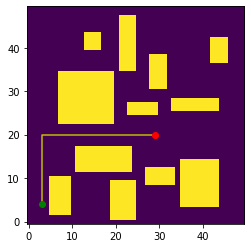

Number of steps taken in A* Path,  43
[ 20.5         20.50312272  20.51249566  20.52813309  20.55005891
  20.57830667  20.61291973  20.65395142  20.70146524  20.75553508
  20.81624554  20.88369225  20.95798219  21.03923421  21.1275794
  21.2231617   21.32613844  21.43668101  21.5549756   21.68122396
  21.81564434  15.3473546   14.68206939  14.07617566  13.52226335
  13.01410871  12.54644618  12.11479096  11.71529958  11.34465937
  11.          10.67882215  10.37893953  10.09843152   9.83560407
   9.58895738   9.35715889   9.13902078   8.93348085   8.73958651
   8.55648105   8.38339198   8.21962102   8.06453552   7.91756097
   7.77817459   7.64589975   7.52030104   7.40098001   7.28757146
   7.17974009   7.07717761   6.97960018   6.88674612   6.79837388
   6.71426024   6.63419872   6.55799811   6.6047797    6.79561409
   7.           7.21932869   7.45519064   7.70941243   7.98410211
   8.28170554   8.60507667   8.95756633  31.81677491  31.59877731
  31.39324429  31.1998101   31.01813562

[ 27.5         27.50418902  27.51676247  27.53773951  27.5671522
  27.60504553  27.65147769  27.7065202   27.77025824  15.98113305
  14.39692621  13.10210766  12.02433586  11.11352871  10.33391374
   9.65925826   9.0698882    8.55075905   8.09016994   7.67888372
   7.309511     6.97607027   6.67366791   6.39826166   6.14648334
   5.91550396   5.70293008   5.50672316   5.32513617   5.15666335
   5.           4.85401007   4.71769979   4.59019615   4.47072912
   4.35861699   4.32623792   4.3824748    4.44156375   4.50365848
   4.56892551   4.63754548   4.70971455   4.78564611   4.86557257
   4.94974747   5.03844789   5.13197715   5.23066792   5.3348858
   5.44503339   5.56155505   5.68494236   5.81574049   5.95455566
   6.10206378   6.25902077   6.42627461   6.6047797    6.79561409
   7.           7.21932869   7.45519064   7.70941243   7.98410211
   8.28170554   8.60507667   8.95756633  11.3246148   11.24702243
  11.17386661  11.10501715  11.04035335  10.97976344  10.92314408
  10.8703998

[ 25.5         25.50388437  25.51554338  25.53499482  25.5622684
  25.59740586  25.64046113  25.69150055  25.7506031   25.81786071
  14.39692621  13.10210766  12.02433586  11.11352871  10.33391374
   9.65925826   9.0698882    8.55075905   8.09016994   7.67888372
   7.309511     6.97607027   6.67366791   6.39826166   6.14648334
   5.91550396   5.70293008   5.50672316   5.32513617   5.15666335
   5.           4.85401007   4.71769979   4.59019615   4.47072912
   4.35861699   4.25325404   4.15410035   4.06067311   3.97253932
   3.88930957   3.81063272   3.73619137   3.66569796   3.59889135
   3.53553391   3.47540898   3.41831865   3.36408182   3.31253248
   3.26351822   3.21689891   3.17254554   3.13033915   3.09016994
   3.05193647   3.01554487   2.98090823   2.94794601   2.91658349
   3.           3.09399801   3.1950817    3.3040339    3.42175805
   3.54930237   3.68789      3.838957     4.00420074   4.18564216
   4.3857066    4.60733023   4.85410197   5.13045543   5.44193292
   5.795554

[ 23.5         23.50357971  23.51432429  23.53225013  23.5573846
  23.58976618  23.62944457  23.6764809   23.73094795  23.79293046
  23.86252538  23.93984233  12.02433586  11.11352871  10.33391374
   9.65925826   9.0698882    8.55075905   8.09016994   7.67888372
   7.309511     6.97607027   6.67366791   6.39826166   6.14648334
   5.91550396   5.70293008   5.50672316   5.32513617   5.15666335
   5.           4.85401007   4.71769979   4.59019615   4.47072912
   4.35861699   4.25325404   4.15410035   4.06067311   3.97253932
   3.88930957   3.81063272   3.73619137   3.66569796   3.59889135
   3.53553391   3.47540898   3.41831865   3.36408182   3.31253248
   3.26351822   3.21689891   3.17254554   3.13033915   3.09016994
   3.05193647   3.01554487   2.98090823   2.94794601   2.91658349
   2.88675135   2.85838517   2.83142513   2.80581559   2.78150485
   2.7584448    2.7365907    2.71590094   2.69633686   2.67786248
   2.66044443   2.6440517    2.62865556   2.61422939   2.60074859
   2.588190

[ 22.5         22.50342738  22.51371475  22.53087778  22.55494271
  22.58594634  22.62393629  22.66897107  10.7779448    9.58867983
   8.63815572   7.8612646    7.21460152   6.66811722   6.20034824
   5.79555496   5.44193292   5.13045543   4.85410197   4.60733023
   4.3857066    4.18564216   4.00420074   3.838957     3.68789
   3.54930237   3.42175805   3.3040339    3.1950817    3.09399801
   3.           2.91240604   2.83061987   2.75411769   2.68243747
   2.61517019   2.55195243   2.49246021   2.43640387   2.38352359
   2.33358574   2.28637963   2.24171482   2.19941878   2.15933481
   2.12132034   2.08524539   2.05099119   2.01844909   1.98751949
   1.95811093   1.93013935   1.90352732   1.87820349   1.85410197
   1.83116188   1.80932692   1.78854494   1.76876761   1.7499501
   1.73205081   1.7150311    1.69885508   1.68348936   1.66890291
   1.65506688   1.64195442   1.62954057   1.61780211   1.60671749
   1.59626666   1.58643102   1.57719334   1.56853763   1.56044915
   1.55291427 

[ 13.5         13.50205643  13.50822885  13.51852667  13.53296562
  13.55156781  13.57436177  28.71403003  28.78008582  28.85525608
  28.93965844  13.10210766  12.02433586  11.11352871  10.33391374
   9.65925826   9.0698882    8.55075905   8.09016994   7.67888372
   7.309511     6.97607027   6.67366791   6.39826166   6.14648334
   5.91550396   5.70293008   5.50672316   5.32513617   5.15666335
   5.           4.85401007   4.71769979   4.59019615   4.47072912
   4.35861699   4.25325404   4.15410035   4.06067311   3.97253932
   3.88930957   3.81063272   3.73619137   3.66569796   3.59889135
   3.53553391   3.47540898   3.41831865   3.36408182   3.31253248
   3.26351822   3.21689891   3.17254554   3.13033915   3.09016994
   3.05193647   3.01554487   2.98090823   2.94794601   2.91658349
   3.           3.09399801   3.1950817    3.3040339    3.42175805
   3.54930237   3.68789      3.838957     4.00420074   4.18564216
   4.3857066    4.60733023   4.85410197   5.13045543   5.44193292
   5.79555

[  2.5          2.50038082   2.50152386   2.50343086   2.50610475
   2.50954959   2.5137707    2.51877456   2.52456893   2.53116281
   2.53856653   2.54679174  28.11436636  28.22336296  28.34187481
  28.47009496  12.69784347  11.97106267  11.32623792  10.7504372
  10.2333154    9.76649838   9.34313507   8.95756633   8.60507667
   8.28170554   7.98410211   7.70941243   7.45519064   7.21932869
   7.           6.79561409   6.6047797    6.42627461   6.25902077
   6.10206378   5.95455566   5.81574049   5.68494236   5.56155505
   5.44503339   5.3348858    5.23066792   5.13197715   5.03844789
   4.94974747   4.86557257   4.78564611   4.70971455   4.63754548
   4.56892551   4.50365848   4.44156375   4.3824748    4.32623792
   4.27271106   4.22176282   4.17327152   4.12712441   4.08321689
   4.04145188   4.00173924   3.96399518   3.92814183   3.89410679
   3.86182272   3.83122697   3.80226132   3.7748716    3.74900748
   3.7246222    3.70167238   3.68011778   3.65992115   3.64104803
   3.623466

[  0.5          0.50007616   0.50030477   0.50068617   0.50122095
   0.50190992   0.50275414   0.50375491   0.50491379   0.50623256
   0.50771331   0.50935835   0.5111703    0.51315205   0.51530681
   0.51763809   0.52014972   0.52284588   0.52573111   0.52881034
   0.53208889   0.5355725    0.53926737   0.54318019   0.54731814
   0.55168896   0.55630097   0.56116312   0.56628503   0.57167703
   0.57735027   0.5833167    0.5895892    0.59618165   0.60310897
   0.61038729   0.61803399   0.62606783   0.63450911   0.64337978
   0.65270364   0.6625065    0.67281636   0.68366373   0.6950818
   0.70710678   4.86557257   4.78564611   4.70971455   4.63754548
   4.56892551   4.50365848   4.44156375   4.3824748    4.32623792
   4.27271106   4.22176282   4.17327152   4.12712441   4.08321689
   4.04145188   4.00173924   3.96399518   3.92814183   3.89410679
   3.86182272   3.83122697   3.80226132   3.7748716    3.74900748
   3.7246222    3.70167238   3.68011778   3.65992115   3.64104803
   3.623466

[  1.5          1.50022849   1.50091432   1.50205852   1.50366285
   1.50572976   1.50826242   1.51126474   1.51474136   1.51869769
   1.52313992   1.52807504   1.53351089   1.53945616   1.54592044
   1.55291427   1.56044915   1.56853763   1.57719334   1.53577674
   1.4619022    1.39521405   1.33473358   1.27965233   1.22929667
   1.18310079   1.14058602   1.10134463   1.06502723   1.03133267
   1.           0.97080201   0.94353996   0.91803923   0.89414582
   0.8717234    0.85065081   0.83082007   0.81213462   0.79450786
   0.77786191   0.76212654   0.74723827   0.73313959   0.71977827
   0.70710678   0.6950818    0.68366373   0.67281636   0.6625065
   0.65270364   0.64337978   0.63450911   0.62606783   0.61803399
   0.61038729   0.60310897   0.59618165   0.5895892    0.5833167
   0.57735027   0.57167703   0.56628503   0.56116312   0.55630097
   0.55168896   0.54731814   0.54318019   0.53926737   0.5355725
   0.53208889   0.52881034   0.52573111   0.52284588   0.52014972
   0.51763809

[  6.5          6.50099013   6.50396204   6.50892025   6.51587234
   6.52482894   6.53580382   6.54881387   6.56387922   6.58102332
   6.60027298   6.62165852   6.64521387   6.6709767    6.69898859
   6.72929517   6.76194633   6.79699642   6.83450446   6.87453443
   6.91715552   6.96244246  23.18849697  16.63548032  15.98085668
  15.38031029  14.82761821  14.31748022  13.84535404   7.21932869
   7.           6.79561409   6.6047797    6.42627461   6.25902077
   6.10206378   5.95455566   5.81574049   5.68494236   5.56155505
   5.44503339   5.3348858    5.23066792   5.13197715   5.03844789
   4.94974747   4.86557257   4.78564611   4.70971455   4.63754548
   4.56892551   4.50365848   4.44156375   4.3824748    4.32623792
   4.27271106   4.22176282   4.17327152   4.12712441   4.08321689
   4.04145188   4.00173924   3.96399518   3.92814183   3.89410679
   3.86182272   3.83122697   3.80226132   3.7748716    3.74900748
   3.7246222    3.70167238   3.68011778   3.65992115   3.64104803
   3.62346

[  2.5          2.50038082   2.50152386   2.50343086   2.50610475
   2.50954959   2.5137707    2.51877456   2.52456893   2.53116281
   2.53856653   2.54679174   2.55585149   2.56576027   2.57653407
   2.58819045   2.60074859   2.61422939   2.62865556   2.6440517
   2.66044443   2.67786248   2.69633686   2.71590094   2.7365907
   2.7584448    2.78150485   2.80581559   2.83142513   2.85838517
   2.88675135   2.91658349   2.94794601   2.98090823   3.01554487
   3.05193647   3.09016994   3.13033915   3.17254554   3.21689891
   3.26351822   3.31253248   3.36408182   3.41831865   3.47540898
   3.53553391   3.59889135   3.66569796   3.73619137   3.81063272
   3.88930957   3.97253932   4.06067311   4.15410035   4.25325404
   4.35861699   4.47072912   4.59019615   4.71769979   4.85401007
   5.           5.15666335   5.32513617   5.50672316   5.70293008
   5.91550396   6.02049953   5.97498208   5.93194108   5.89129747
   5.85297775   5.81691375   5.78304223   5.75130466   5.7216469
   5.69401899

[ 21.5         21.50327505  14.32685417   9.5536613    7.16779351
   6.52482894   6.53580382   6.54881387   6.56387922   6.58102332
   6.60027298   6.62165852   6.64521387   6.6709767    6.69898859
   6.72929517   6.76194633   6.79699642   6.83450446   6.87453443
   6.91715552   6.96244246   7.01047583   7.06134245   7.11513581
   7.17195647   7.23191261   7.29512054   7.36170533   7.43180144
   7.5055535    7.58311708   7.66465962   7.7503614    7.84041667
  14.81929776  14.46106374  14.39956007  14.59370947  14.79773501
  15.01218383   8.38339198   8.21962102   8.06453552   7.91756097
   7.77817459   7.64589975   7.52030104   7.40098001   7.28757146
   7.17974009   7.07717761   6.97960018   6.88674612   6.79837388
   6.71426024   6.63419872   6.55799811   6.48548122   6.41648368
   6.35085296   6.28844737   6.22913528   6.17279431   6.11931067
   6.06857855   6.02049953   5.97498208   5.93194108   5.89129747
   5.85297775   5.81691375   5.78304223   5.75130466   5.7216469
   5.694018

[ 19.5         19.5029704   14.32685417   9.5536613    7.16779351
   5.73685662   4.78338612   4.53379421   4.54422408   4.55609307
   4.56941975   4.58422513   4.60053268   4.61836849   4.63776133
   4.65874281   4.68134746   4.7056129    4.73158001   4.75929307
   4.78879998   4.82015247   4.85340634   4.8886217    4.92586325
   4.96520064   5.00670873   5.05046807   5.09656523   5.14509331
   5.19615242   5.24985029   5.30630282   5.36563482   5.42798077
   5.49348565   5.5623059    5.63461046   5.71058197   5.79041805
   5.8743328    5.96255847   6.05534728   6.15297357   6.25573616
   6.36396103  13.67578713  13.92965226  14.19752722  14.48040432
  14.77937636   7.07717761   6.97960018   6.88674612   6.79837388
   6.71426024   6.63419872   6.55799811   6.48548122   6.41648368
   6.35085296   6.28844737   6.22913528   6.17279431   6.11931067
   6.06857855   6.02049953   5.97498208   5.93194108   5.89129747
   5.85297775   5.81691375   5.78304223   5.75130466   5.7216469
   5.694018

[ 17.5         17.50266574  14.32685417   9.5536613    7.16779351
   5.73685662   4.78338612   4.10275452   3.59264827   3.19622661
   2.87938524   2.62042153   2.55585149   2.56576027   2.57653407
   2.58819045   2.60074859   2.61422939   2.62865556   2.6440517
   2.66044443   2.67786248   2.69633686   2.71590094   2.7365907
   2.7584448    2.78150485   2.80581559   2.83142513   2.85838517
   2.88675135   2.91658349   2.94794601   2.98090823   3.01554487
   3.05193647   3.09016994   3.13033915   3.17254554   3.21689891
   3.26351822   3.31253248   3.36408182   3.41831865   3.47540898
   3.53553391   3.59889135   3.66569796   3.73619137   3.81063272
   3.88930957   3.97253932   4.06067311   4.15410035   4.25325404
   4.35861699   4.47072912   4.59019615   4.71769979   4.85401007
   5.          29.15552873  28.88053629  28.61931906  28.37134948
  28.13613693   6.02049953   5.97498208   5.93194108   5.89129747
   5.85297775   5.81691375   5.78304223   5.75130466   5.7216469
   5.69401899

[ 15.5         15.50236108  15.50944794   9.5536613    7.16779351
   5.73685662   4.78338612   4.10275452   3.59264827   3.19622661
   2.87938524   2.62042153   2.40486717   2.22270574   2.06678275
   1.93185165   1.81397764   1.71015181   1.61803399   1.53577674
   1.4619022    1.39521405   1.33473358   1.27965233   1.22929667
   1.18310079   1.14058602   1.10134463   1.06502723   1.03133267
   1.           0.97080201   0.94353996   0.91803923   0.89414582
   0.8717234    0.85065081   0.83082007   0.81213462   0.79450786
   0.77786191   0.76212654   0.74723827   0.73313959   0.71977827
   0.70710678   0.71977827   0.73313959   0.74723827   0.76212654
   0.77786191   0.79450786   0.81213462   0.83082007   0.85065081
   0.8717234    0.89414582   0.91803923   0.94353996   0.97080201
   1.           1.03133267   1.06502723   1.10134463   1.14058602
   1.18310079   1.22929667   1.27965233   1.33473358   1.39521405
   1.4619022    1.53577674   1.61803399   1.71015181   1.81397764
   1.93185

[  3.5          3.50053315   3.50213341   3.50480321   3.50854664
   3.51336943   3.51927898   3.52628439   3.5343965    3.19622661
   2.87938524   2.62042153   2.40486717   2.22270574   2.06678275
   1.93185165   1.81397764   1.71015181   1.61803399   1.53577674
   1.4619022    1.39521405   1.33473358   1.27965233   1.22929667
   1.18310079   1.14058602   1.10134463   1.06502723   1.03133267
   1.           0.97080201   0.94353996   0.91803923   0.89414582
   0.8717234    0.85065081   0.83082007   0.81213462   0.79450786
   0.77786191   0.76212654   0.74723827   0.73313959   0.71977827
   0.70710678   0.6950818    0.68366373   0.67281636   0.6625065
   0.65270364   0.64337978   0.63450911   0.62606783   0.61803399
   0.61038729   0.60310897   0.59618165   0.5895892    0.5833167
   0.57735027   0.57167703   0.56628503   0.56116312   0.55630097
   0.55168896   0.54731814   0.54318019   0.53926737   0.5355725
   0.53208889   0.52881034   0.52573111   0.52284588   0.52014972
   0.51763809

[  2.5          2.50038082   2.50152386   2.50343086   2.50610475
   2.50954959   2.5137707    2.51877456   2.52456893   2.53116281
   2.53856653   2.54679174   2.55585149   2.56576027   2.57653407
   2.58819045   2.60074859   2.61422939   2.62865556   2.6440517
   2.66044443   2.67786248   2.69633686   2.71590094   2.7365907
   2.7584448    2.78150485   2.80581559   2.83142513   2.85838517
   2.88675135   2.91240604   2.83061987   2.75411769   2.68243747
   2.61517019   2.55195243   2.49246021   2.43640387   2.38352359
   2.33358574   2.28637963   2.24171482   2.19941878   2.15933481
   2.12132034   2.08524539   2.05099119   2.01844909   1.98751949
   1.95811093   1.93013935   1.90352732   1.87820349   1.85410197
   1.83116188   1.80932692   1.78854494   1.76876761   1.7499501
   1.73205081   1.7150311    1.69885508   1.68348936   1.66890291
   1.65506688   1.64195442   1.62954057   1.61780211   1.60671749
   1.59626666   1.58643102   1.57719334   1.56853763   1.56044915
   1.55291427

[  1.5          1.50022849   1.50091432   1.50205852   1.50366285
   1.50572976   1.50826242   1.51126474   1.51474136   1.51869769
   1.52313992   1.52807504   1.53351089   1.53945616   1.54592044
   1.55291427   1.56044915   1.56853763   1.57719334   1.53577674
   1.4619022    1.39521405   1.33473358   1.27965233   1.22929667
   1.18310079   1.14058602   1.10134463   1.06502723   1.03133267
   1.           0.97080201   0.94353996   0.91803923   0.89414582
   0.8717234    0.85065081   0.83082007   0.81213462   0.79450786
   0.77786191   0.76212654   0.74723827   0.73313959   0.71977827
   0.70710678   0.6950818    0.68366373   0.67281636   0.6625065
   0.65270364   0.64337978   0.63450911   0.62606783   0.61803399
   0.61038729   0.60310897   0.59618165   0.5895892    0.5833167
   0.57735027   0.57167703   0.56628503   0.56116312   0.55630097
   0.55168896   0.54731814   0.54318019   0.53926737   0.5355725
   0.53208889   0.52881034   0.52573111   0.52284588   0.52014972
   0.51763809

[ 10.5         10.50159944  10.50640022  10.51440963  10.52563993
  10.54010829  10.55783694  10.57885317  10.60318951   9.58867983
   8.63815572   7.8612646    7.21460152   6.66811722   6.20034824
   5.79555496   5.44193292   5.13045543   4.85410197   4.60733023
   4.3857066    4.18564216   4.00420074   3.838957     3.68789
   3.54930237   3.42175805   3.3040339    3.1950817    3.09399801
   3.           2.91240604   2.83061987   2.75411769   2.68243747
   2.61517019   2.55195243   2.49246021   2.43640387   2.38352359
   2.33358574   2.28637963   2.24171482   2.19941878   2.15933481
   2.12132034   2.08524539   2.05099119   2.01844909   1.98751949
   1.95811093   1.93013935   1.90352732   1.87820349   1.85410197
   1.83116188   1.80932692   1.78854494   1.76876761   1.7499501
   1.73205081   1.7150311    1.69885508   1.68348936   1.66890291
   1.65506688   1.64195442   1.62954057   1.61780211   1.60671749
   1.59626666   1.58643102   1.57719334   1.56853763   1.56044915
   1.55291427 

[  1.5          1.50022849   1.50091432   1.50205852   1.50366285
   1.50572976   1.50826242   1.51126474   1.51474136   1.51869769
   1.52313992   1.52807504   1.53351089   1.53945616   1.54592044
   1.55291427   1.56044915   1.56853763   1.57719334   1.58643102
   1.59626666   1.60671749   1.61780211   1.62954057   1.64195442
   1.65506688   1.66890291   1.68348936   1.69885508   1.7150311
   1.73205081   1.7499501    1.76876761   1.78854494   1.80932692
   1.83116188   1.85410197   1.87820349   1.90352732   1.93013935
   1.95811093   1.98751949   2.01844909   2.05099119   2.08524539
   2.12132034   2.15933481   2.19941878   2.24171482   2.28637963
   2.33358574   2.38352359   2.43640387   2.49246021   2.55195243
   2.61517019   2.68243747   2.75411769   2.83061987   2.91240604
   3.           3.09399801   3.1950817    3.3040339    3.42175805
   3.54930237   3.68789      3.80226132   3.7748716    3.74900748
   3.7246222    3.70167238   3.68011778   3.65992115   3.64104803
   3.623466

[ 16.5         16.50251341  16.51005748  16.52264371  16.54029132
  16.56302732  16.59088661  16.62391212  16.66215495   9.58867983
   8.63815572   7.8612646    7.21460152   6.6709767    6.69898859
   6.72929517   6.76194633   6.79699642   6.83450446   6.87453443
   6.91715552   6.96244246   7.01047583   7.06134245   7.11513581
   7.17195647   7.23191261   7.29512054   7.36170533   7.43180144
   7.5055535    7.58311708   7.66465962   7.7503614    7.84041667
   7.93503483   8.03444185   8.13888178   8.2486184    8.36393718
   8.48514738   8.61258446   8.74661274   8.8876285    9.03606334
   9.19238816   9.35711751   9.53081471   9.71409757   9.90764506
  10.11220487  10.32860224  10.5577501   35.68586626  14.21478174
  14.03890777  13.87150641  13.71217787  13.56055164  13.41628407
  13.27905619  13.14857178   7.36170533   7.29512054   7.23191261
   7.17195647   7.11513581   7.06134245   7.01047583   6.96244246
   6.91715552   6.87453443   6.83450446   6.79699642   6.76194633
   6.72929

[  4.5          4.50068548   4.50274295   4.50617556   4.51098854
   4.51718927   4.52478726   4.53379421   4.54422408   4.55609307
   4.56941975   4.58422513   4.60053268   4.61836849   4.63776133
   4.65874281   4.68134746   4.7056129    4.73158001   1.53577674
   1.4619022    1.39521405   1.33473358   1.27965233   1.22929667
   1.18310079   1.14058602   1.10134463   1.06502723   1.03133267
   1.           0.97080201   0.94353996   0.91803923   0.89414582
   0.8717234    0.85065081   0.83082007   0.81213462   0.79450786
   0.77786191   0.76212654   0.74723827   0.73313959   0.71977827
   0.70710678   0.6950818    0.68366373   0.67281636   0.6625065
   0.65270364   0.64337978   0.63450911   0.62606783   0.61803399
   0.61038729   0.60310897   0.59618165   0.5895892    0.5833167
   0.57735027   0.57167703   0.56628503   0.56116312   0.55630097
   0.55168896   0.54731814   0.54318019   0.53926737   0.5355725
   0.53208889   0.52881034   0.52573111   0.52284588   0.52014972
   0.51763809

[  5.5          5.5008378    5.50335249   5.5075479    5.51343044
   5.52100911   5.53029554   5.54130404   5.55405165   5.56855819
   5.58484637   5.60294182   5.62287327   5.64467259   5.66837496
   5.69401899   5.7216469    5.75130466   5.78304223   5.81691375
   5.85297775   5.89129747   5.93194108   5.97498208   6.02049953
   6.06857855   6.11931067   6.17279431   6.22913528   6.28844737
   6.35085296   6.41648368   6.48548122   6.55799811   6.63419872
   6.71426024   6.79837388   6.88674612   6.97960018   7.07717761
   7.17974009   7.28757146   7.40098001   7.52030104   7.64589975
  26.1629509   26.63179598  34.86685026  34.3136346   11.26261044
  11.09596196  10.93745631  10.78665483  10.64315309  10.50657781
   4.27271106   4.22176282   4.17327152   4.12712441   4.08321689
   4.04145188   4.00173924   3.96399518   3.92814183   3.89410679
   3.86182272   3.83122697   3.80226132   3.7748716    3.74900748
   3.7246222    3.70167238   3.68011778   3.65992115   3.64104803
   3.62346

[  3.5          3.50053315   3.50213341   3.50480321   3.50854664
   3.51336943   3.51927898   3.52628439   3.5343965    3.54362794
   3.55399314   3.56550843   3.57819208   3.59206438   3.6071477
   3.62346663   3.64104803   3.65992115   3.68011778   3.70167238
   3.7246222    3.74900748   3.7748716    3.80226132   3.83122697
   3.86182272   3.89410679   3.92814183   3.96399518   4.00173924
   4.04145188   4.08321689   4.12712441   4.17327152   4.22176282
   4.27271106   4.32623792   4.3824748    4.44156375   4.50365848
   4.56892551   4.63754548   4.70971455   4.78564611   4.86557257
   4.94974747   5.03844789   5.13197715   5.23066792   5.3348858
   5.44503339   5.56155505   5.68494236   5.81574049   5.95455566
   6.10206378   6.25902077   6.42627461   6.6047797    6.79561409
   7.           7.21932869   7.45519064   7.70941243   7.98410211
   8.28170554   8.60507667   8.95756633   9.34313507   9.76649838
  15.4305777   15.33549988  15.24620225  15.16253047  15.08434182
  15.0115046

[  2.5          2.50038082   2.50152386   2.50343086   2.50610475
   2.50954959   2.5137707    2.51877456   2.52456893   2.53116281
   2.53856653   2.54679174   2.55585149   2.56576027   2.57653407
   2.58819045   2.60074859   2.61422939   2.62865556   2.6440517
   2.66044443   2.67786248   2.69633686   2.71590094   2.7365907
   2.7584448    2.78150485   2.80581559   2.83142513   2.85838517
   2.88675135   2.91658349   2.94794601   2.98090823   3.01554487
   3.05193647   3.09016994   3.13033915   3.17254554   3.21689891
   3.26351822   3.31253248   3.36408182   3.41831865   3.47540898
   3.53553391   3.59889135   3.66569796   3.73619137   3.81063272
   3.88930957   3.97253932   4.06067311   4.15410035   4.25325404
   4.35861699   4.47072912   4.59019615   4.71769979   4.85401007
   5.           5.15666335   5.32513617   5.50672316   5.70293008
   5.91550396   6.14648334   6.39826166   6.67366791   6.97607027
   7.309511     7.67888372   8.09016994   8.55075905   9.0698882
   9.65925826

[  0.5          0.50007616   0.50030477   0.50068617   0.50122095
   0.50190992   0.50275414   0.50375491   0.50491379   0.50623256
   0.50771331   0.50935835   0.5111703    0.51315205   0.51530681
   0.51763809   0.52014972   0.52284588   0.52573111   0.52881034
   0.53208889   0.5355725    0.53926737   0.54318019   0.54731814
   0.55168896   0.55630097   0.56116312   0.56628503   0.57167703
   0.57735027   0.5833167    0.5895892    0.59618165   0.60310897
   0.61038729   0.61803399   0.62606783   0.63450911   0.64337978
   0.65270364   0.6625065    0.67281636   0.68366373   0.6950818
   0.70710678   0.71977827   0.73313959   0.74723827   0.76212654
   0.77786191   0.79450786   0.81213462   0.83082007   0.85065081
   0.8717234    0.89414582   0.91803923   0.94353996   0.97080201
   1.           1.03133267   1.06502723   1.10134463   1.14058602
   1.18310079   1.22929667   1.27965233   1.33473358   1.39521405
   1.4619022    1.53577674   1.61803399   1.71015181   1.81397764
   1.931851

[ 14.5         14.50220876  14.50883839  14.51989902  14.53540752
  14.55538764  14.57987005  14.60889247  14.6424998   14.68074432
  14.72368587  14.77139208  14.82393863  14.88140956  14.94389763
  15.01150462  15.08434182  15.16253047  15.24620225  15.33549988
  15.4305777   15.53160241  15.63875377   8.95756633   8.60507667
   8.28170554   7.98410211   7.70941243   7.45519064   7.21932869
   7.           6.79561409   6.6047797    6.42627461   6.25902077
   6.10206378   5.95455566   5.81574049   5.71058197   5.79041805
   5.8743328    5.96255847   6.05534728   6.15297357   6.25573616
   6.36396103   6.47800443   6.59825634   6.72514447   6.85913889
   7.00075722   7.15057078   7.3092116    7.47738064   7.65585728
   7.84551058   8.04731242   8.26235306   8.49185962   8.73721812
  23.67136104  23.43875839  23.21768604  23.00768787  22.80833978
  22.61924734  22.44004371  22.27038774  22.10996222  21.95847237
  21.81564434  21.68122396  21.5549756   21.43668101  21.32613844
  21.22316

[ 19.5         19.5029704   19.51188611  19.52676075  19.54761701
  19.57448683  19.60741145  12.30826357  10.7779448    9.58867983
   8.63815572   7.8612646    7.21460152   6.66811722   6.20034824
   5.79555496   5.44193292   5.13045543   4.85410197   4.60733023
   4.3857066    4.18564216   4.00420074   3.838957     3.68789
   3.54930237   3.42175805   3.3040339    3.1950817    3.09399801
   3.           2.91240604   2.83061987   2.75411769   2.68243747
   2.61517019   2.55195243   2.49246021   2.43640387   2.38352359
   2.33358574   2.28637963   2.24171482   2.19941878   2.15933481
   2.12132034   2.08524539   2.05099119   2.01844909   1.98751949
   1.95811093   1.93013935   1.90352732   1.87820349   1.85410197
   1.83116188   1.80932692   1.78854494   1.76876761   1.7499501
   1.73205081   1.7150311    1.69885508   1.68348936   1.66890291
   1.65506688   1.64195442   1.62954057   1.61780211   1.60671749
   1.59626666   1.58643102   1.57719334   1.56853763   1.56044915
   1.55291427 

[ 17.5         17.50266574  17.51066703  17.52401605  17.54273322
  17.56684716  17.59639489  17.63142195  17.67198252   9.58867983
   8.63815572   7.8612646    7.21460152   6.66811722   6.20034824
   5.79555496   5.44193292   5.13045543   4.85410197   4.60733023
   4.3857066    4.18564216   4.00420074   3.838957     3.68789
   3.54930237   3.42175805   3.3040339    3.1950817    3.09399801
   3.           2.91240604   2.83061987   2.75411769   2.68243747
   2.61517019   2.55195243   2.49246021   2.43640387   2.38352359
   2.33358574   2.28637963   2.24171482   2.19941878   2.15933481
   2.12132034   2.08524539   2.05099119   2.01844909   1.98751949
   1.95811093   1.93013935   1.90352732   1.87820349   1.85410197
   1.83116188   1.80932692   1.78854494   1.76876761   1.7499501
   1.73205081   1.7150311    1.69885508   1.68348936   1.66890291
   1.65506688   1.64195442   1.62954057   1.61780211   1.60671749
   1.59626666   1.58643102   1.57719334   1.56853763   1.56044915
   1.55291427 

[ 15.5         15.50236108  15.50944794  15.52127136  15.53784942
  15.55920748  15.58537833  15.61640229  15.65232737  15.69320945
  15.73911248   7.8612646    7.21460152   6.66811722   6.20034824
   5.79555496   5.44193292   5.13045543   4.85410197   4.60733023
   4.3857066    4.18564216   4.00420074   3.838957     3.68789
   3.54930237   3.42175805   3.3040339    3.1950817    3.09399801
   3.           2.91240604   2.83061987   2.75411769   2.68243747
   2.61517019   2.55195243   2.49246021   2.43640387   2.38352359
   2.33358574   2.28637963   2.24171482   2.19941878   2.15933481
   2.12132034   2.08524539   2.05099119   2.01844909   1.98751949
   1.95811093   1.93013935   1.90352732   1.87820349   1.85410197
   1.83116188   1.80932692   1.78854494   1.76876761   1.7499501
   1.73205081   1.7150311    1.69885508   1.68348936   1.66890291
   1.65506688   1.64195442   1.62954057   1.61780211   1.60671749
   1.59626666   1.58643102   1.57719334   1.56853763   1.56044915
   1.55291427 

[  4.5          4.50068548   4.50274295   4.50617556   4.51098854
   4.51718927   4.52478726   4.53379421   4.54422408   4.55609307
   4.56941975   4.58422513   4.60053268   4.61836849   4.63776133
   4.65874281   4.68134746   4.7056129    4.73158001   4.75929307
   4.78879998   4.82015247   4.85340634   4.8886217    4.92586325
   4.96520064   5.00670873   5.05046807   5.09656523   5.14509331
   5.19615242   5.24985029   5.30630282   5.36563482   5.42798077
   5.49348565   5.5623059    5.63461046   5.71058197   5.79041805
   5.8743328    5.96255847   6.05534728   6.15297357   6.25573616
   6.36396103   6.47800443   6.59825634   6.72514447   6.85913889
   7.00075722   7.15057078   7.3092116    7.47738064   7.65585728
   7.84551058   8.04731242   8.26235306   8.49185962   8.73721812
   9.           9.28199403   9.58524511   9.91210169  10.26527415
  10.64790712  11.06367001  13.57950472  13.48168428  13.38931242
  13.30222216  13.22025851  13.1432778   13.07114696  13.00374295
  12.94095

[  0.5          0.50007616   0.50030477   0.50068617   0.50122095
   0.50190992   0.50275414   0.50375491   0.50491379   0.50623256
   0.50771331   0.50935835   0.5111703    0.51315205   0.51530681
   0.51763809   0.52014972   0.52284588   0.52573111   0.52881034
   0.53208889   0.5355725    0.53926737   0.54318019   0.54731814
   0.55168896   0.55630097   0.56116312   0.56628503   0.57167703
   0.57735027   0.5833167    0.5895892    0.59618165   0.60310897
   0.61038729   0.61803399   0.62606783   0.63450911   0.64337978
   0.65270364   0.6625065    0.67281636   0.68366373   0.6950818
   0.70710678   0.71977827   0.73313959   0.74723827   0.76212654
   0.77786191   0.79450786   0.81213462   0.83082007   0.85065081
   0.8717234    0.89414582   0.91803923   0.94353996   0.97080201
   1.           1.03133267   1.06502723   1.10134463   1.14058602
   1.18310079   1.22929667   1.27965233   1.33473358   1.39521405
   1.4619022    1.53577674   1.61803399   1.71015181   1.81397764
   1.931851

[  2.5          2.50038082   2.50152386   2.50343086   2.50610475
   2.50954959   2.5137707    2.51877456   2.52456893   2.53116281
   2.53856653   2.54679174   2.55585149   2.56576027   2.57653407
   2.58819045   2.60074859   2.61422939   2.62865556   2.6440517
   2.66044443   2.67786248   2.69633686   2.71590094   2.7365907
   2.7584448    2.78150485   2.80581559   2.83142513   2.85838517
   2.88675135   2.91658349   2.94794601   2.98090823   3.01554487
   3.05193647   3.09016994   3.13033915   3.17254554   3.21689891
   3.26351822   3.31253248   3.36408182   3.41831865   3.47540898
   3.53553391   3.59889135   3.66569796   3.73619137   3.81063272
   3.88930957   3.97253932   4.06067311   4.15410035   4.25325404
   4.27271106   4.22176282   4.17327152   4.12712441   4.08321689
   4.04145188   4.00173924   3.96399518   3.92814183   3.89410679
   3.86182272   3.83122697   3.80226132   3.7748716    3.74900748
   3.7246222    3.70167238   3.68011778   3.65992115   3.64104803
   3.6234666

[  7.5          7.50114246   7.50457158   7.51029259   7.51831424
   7.52864878   7.5413121    7.55632369   7.57370679   7.59348844
   7.61569959   7.64037521   7.66755446   7.69728081   7.72960222
   7.76457135   7.80224577   7.84268817   7.88596668   1.53577674
   1.4619022    1.39521405   1.33473358   1.27965233   1.22929667
   1.18310079   1.14058602   1.10134463   1.06502723   1.03133267
   1.           0.97080201   0.94353996   0.91803923   0.89414582
   0.8717234    0.85065081   0.83082007   0.81213462   0.79450786
   0.77786191   0.76212654   0.74723827   0.73313959   0.71977827
   0.70710678   0.6950818    0.68366373   0.67281636   0.6625065
   0.65270364   0.64337978   0.63450911   0.62606783   0.61803399
   0.61038729   0.60310897   0.59618165   0.5895892    0.5833167
   0.57735027   0.57167703   0.56628503   0.56116312   0.55630097
   0.55168896   0.54731814   0.54318019   0.53926737   0.5355725
   0.53208889   0.52881034   0.52573111   0.52284588   0.52014972
   0.51763809

[  5.5          5.5008378    5.50335249   5.5075479    5.51343044
   5.52100911   5.53029554   5.54130404   5.55405165   5.56855819
   5.58484637   5.60294182   5.62287327   5.64467259   5.66837496
   5.69401899   5.7216469    5.75130466   5.78304223   5.81691375
   5.85297775   5.89129747   5.93194108   5.97498208   6.02049953
   6.06857855   6.11931067   6.17279431   6.22913528   6.28844737
   6.35085296   6.41648368   6.48548122   6.55799811   6.63419872
   6.71426024   6.79837388   6.88674612   6.97960018   7.07717761
   7.17974009   7.28757146   7.40098001   7.52030104   7.64589975
   7.77817459   7.91756097   8.06453552   8.21962102   8.38339198
   8.55648105   8.73958651   8.93348085   9.13902078   9.35715889
   9.58895738   9.83560407  10.09843152  10.37893953  10.67882215
  11.          11.34465937  11.71529958  12.11479096  12.54644618
  13.01410871  13.52226335  14.07617566  14.68206939  15.3473546
  16.0809242   16.89354418  17.79837388  18.29960574  18.20524013
  18.117333

[  3.5          3.50053315   3.50213341   3.50480321   3.50854664
   3.51336943   3.51927898   3.52628439   3.5343965    3.54362794
   3.55399314   3.56550843   3.57819208   3.59206438   3.6071477
   3.62346663   3.64104803   3.65992115   3.68011778   3.70167238
   3.7246222    3.74900748   3.7748716    3.80226132   3.83122697
   3.86182272   3.89410679   3.92814183   3.96399518   4.00173924
   4.04145188   4.08321689   4.12712441   4.17327152   4.22176282
   4.27271106   4.32623792   4.3824748    4.44156375   4.50365848
   4.56892551   4.63754548   4.70971455   4.78564611   4.86557257
   4.94974747   5.03844789   5.13197715   5.23066792   5.3348858
   5.44503339   5.56155505   5.68494236   5.81574049   5.95455566
   6.10206378   6.25902077   6.42627461   6.6047797    6.79561409
   7.           7.21932869   7.45519064   7.70941243   7.98410211
   8.28170554   8.60507667   8.95756633   9.34313507   9.76649838
  10.2333154   10.7504372   11.32623792  11.97106267  12.69784347
  13.5229615

[  1.5          1.50022849   1.50091432   1.50205852   1.50366285
   1.50572976   1.50826242   1.51126474   1.51474136   1.51869769
   1.52313992   1.52807504   1.53351089   1.53945616   1.54592044
   1.55291427   1.56044915   1.56853763   1.57719334   1.58643102
   1.59626666   1.60671749   1.61780211   1.62954057   1.64195442
   1.65506688   1.66890291   1.68348936   1.69885508   1.7150311
   1.73205081   1.7499501    1.76876761   1.78854494   1.80932692
   1.83116188   1.85410197   1.87820349   1.90352732   1.93013935
   1.95811093   1.98751949   2.01844909   2.05099119   2.08524539
   2.12132034   2.15933481   2.19941878   2.24171482   2.28637963
   2.33358574   2.38352359   2.43640387   2.49246021   2.55195243
   2.61517019   2.68243747   2.75411769   2.83061987   2.91240604
   3.           3.09399801   3.1950817    3.3040339    3.42175805
   3.54930237   3.68789      3.838957     4.00420074   4.18564216
   4.3857066    4.60733023   4.85410197   5.13045543   5.44193292
   5.795554

[ 16.5         16.50251341  16.51005748  16.52264371  16.54029132
  16.56302732  16.59088661  16.62391212  16.66215495  16.70567458
  16.7545391   16.80882547  16.86861982  16.93401778  17.00512488
  17.08205698  17.16494069  17.25391398  17.3491267   17.45074124
  17.55893325  17.6738924   17.79582325  17.92494623  18.0614986
  18.20573566  18.35793202  18.51838292  18.68740584  18.86534212
  19.05255888  19.24945105  19.45644366  19.67399433  19.90259615
  20.14278071  20.39512163  20.66023836  20.93880055  21.23153284
  21.53922027  21.86271439  22.20294004  22.56090311  22.93769925
  23.33452378  23.7526829   24.19360656  24.65886307  25.15017593
  25.66944314  26.21875953  26.80044255  27.41706233  28.07147668
  28.76687213  29.50681222  17.28926775   6.48548122   6.41648368
   6.35085296   6.28844737   6.22913528   6.17279431   6.11931067
   6.06857855   6.02049953   5.97498208   5.93194108   5.89129747
   5.85297775   5.81691375   5.78304223   5.75130466   5.7216469
   5.6940189

[  3.5          3.50053315   3.50213341   3.50480321   3.50854664
   3.51336943   3.51927898   3.52628439   3.5343965   12.65581407
  12.69283265  12.73395869  12.77925744  12.82880135  12.88267037
  12.94095226  38.09353042  22.23197353  21.03444185  20.62360328
  13.1571198   12.55692649  12.01260223  11.51687099  11.06367001
  10.64790712  10.26527415   9.91210169   9.58524511   9.28199403
   9.           8.73721812   8.49185962   8.26235306   8.04731242
   7.84551058   7.65585728   7.47738064   7.3092116    7.15057078
   7.00075722   6.85913889   6.72514447   6.59825634   6.47800443
   6.36396103   6.25573616   6.15297357   6.05534728   5.96255847
   5.8743328    5.79041805   5.71058197   5.63461046   5.5623059
   5.49348565   5.42798077   5.36563482   5.30630282   5.24985029
   5.19615242   5.14509331   5.09656523   5.05046807   5.00670873
   4.96520064   4.92586325   4.8886217    4.85340634   4.82015247
   4.78879998   4.75929307   4.73158001   4.7056129    4.68134746
   4.658742

[  1.5          1.50022849   1.50091432   1.50205852   1.50366285
   1.50572976   1.50826242   1.51126474   1.51474136   1.51869769
   1.52313992   1.52807504   1.53351089   1.53945616   1.54592044
   1.55291427   1.56044915   1.56853763   1.57719334  19.96509766
  19.0047286   18.74503739  18.874358    19.0113066   11.06367001
  10.64790712  10.26527415   9.91210169   9.58524511   9.28199403
   9.           8.73721812   8.49185962   8.26235306   8.04731242
   7.84551058   7.65585728   7.47738064   7.3092116    7.15057078
   7.00075722   6.85913889   6.72514447   6.59825634   6.47800443
   6.36396103   6.25573616   6.15297357   6.05534728   5.96255847
   5.8743328    5.79041805   5.71058197   5.63461046   5.5623059
   5.49348565   5.42798077   5.36563482   5.30630282   5.24985029
   5.19615242   5.14509331   5.09656523   5.05046807   5.00670873
   4.96520064   4.92586325   4.8886217    4.85340634   4.82015247
   4.78879998   4.75929307   4.73158001   4.7056129    4.68134746
   4.658742

[  3.5          3.50053315   3.50213341   3.50480321   3.50854664
   3.51336943   3.51927898   3.52628439   3.5343965    3.54362794
   3.55399314   3.56550843   3.57819208   3.59206438   3.6071477
   3.62346663   3.64104803   3.65992115   3.68011778   3.70167238
   3.7246222    3.74900748   3.7748716    3.80226132   3.83122697
   3.86182272   3.89410679   3.92814183   3.96399518   4.00173924
   4.04145188   4.08321689   4.12712441   4.17327152   4.22176282
   4.27271106   4.32623792   4.3824748    4.44156375   4.50365848
   4.56892551   4.63754548   4.70971455   4.78564611   4.86557257
   4.94974747   5.03844789   5.13197715   5.23066792   5.3348858
   5.44503339   5.56155505   5.68494236   5.81574049   5.95455566
   6.10206378   6.25902077   6.42627461   6.6047797    6.79561409
   7.           7.21932869   7.45519064   7.70941243   7.98410211
   8.28170554   8.60507667   8.95756633   9.34313507   9.76649838
  10.2333154   10.7504372   11.32623792  11.97106267  12.69784347
  13.5229615

[  1.5          1.50022849   1.50091432   1.50205852   1.50366285
   1.50572976   1.50826242   1.51126474   1.51474136   1.51869769
   1.52313992   1.52807504   1.53351089   1.53945616   1.54592044
   1.55291427   1.56044915   1.56853763   1.57719334   1.58643102
   1.59626666   1.60671749   1.61780211   1.62954057   1.64195442
   1.65506688   1.66890291   1.68348936   1.69885508   1.7150311
   1.73205081   1.7499501    1.76876761   1.78854494   1.80932692
   1.83116188   1.85410197   1.87820349   1.90352732   1.93013935
   1.95811093   1.98751949   2.01844909   2.05099119   2.08524539
   2.12132034   2.15933481   2.19941878   2.24171482   2.28637963
   2.33358574   2.38352359   2.43640387   2.49246021   2.55195243
   2.61517019   2.68243747   2.75411769   2.83061987   2.91240604
   3.           3.09399801   3.1950817    3.3040339    3.42175805
   3.54930237   3.68789      3.838957     4.00420074   4.18564216
   4.3857066    4.60733023   4.85410197   5.13045543   5.44193292
   5.795554

[ 14.5         14.50220876  14.50883839  14.51989902  14.53540752
  14.55538764  14.57987005  14.60889247  14.6424998   14.68074432
  14.72368587  14.77139208  14.82393863  14.88140956  14.94389763
  15.01150462  15.08434182  15.16253047  15.24620225  15.33549988
  15.4305777   15.53160241  15.63875377  15.75222547  15.87222604
  15.99897982  16.13272814  16.27373045  16.42226573  16.57863398
  16.74315781  16.91618426  17.09808685  17.28926775  17.49016025
  17.70123154  17.92298567  18.15596704  18.40076412  18.65801371
  18.9284057   19.2126884   19.51167458  19.82624819  20.15737207
  20.50609665  20.87356982  21.26104819  21.66990997  22.10166976
  22.55799549  23.04072807  23.55190406  24.09378205  24.66887344
  25.27997854  25.93022892  26.62313765  27.36265876  28.15325838
  29.          29.90864742  30.88578979  16.27373045  16.13272814
  15.99897982  15.87222604  15.75222547  15.63875377  15.53160241
  15.4305777   15.33549988  15.24620225  15.16253047  15.08434182
   5.69401

[ 12.5         12.5019041   12.5076193   12.51715432  12.53052373
  12.54774797  12.56885349  12.59387282  12.62284466  12.65581407
  12.69283265  12.73395869  12.77925744  12.82880135  12.88267037
  12.94095226  13.00374295  13.07114696  13.1432778   13.22025851
  13.30222216  13.38931242  13.48168428  13.57950472  13.68295348
  13.79222399  13.90752426  14.02907797  14.15712563  14.29192585
  14.43375673  14.58291747  14.73973004  14.90454116  15.07772436
  15.25968236  15.45084972  15.65169573  15.86272769  16.08449457
  16.31759112  16.56266242  16.82040912  17.09159326  17.37704489
  17.67766953  17.99445675  18.32848982  18.68095687  19.05316358
  19.44654784  19.86269661  20.30336557  20.77050176  21.26627021
  21.79308495  22.35364562  22.95098073  23.58849893  24.27005033
  25.          25.78331675  26.62568085  27.53361581  28.51465041
  29.57751979  30.73241669  31.99130832  33.36833953  34.88035137
  15.4305777   15.33549988  15.24620225  15.16253047  15.08434182
  15.01150

[ 10.5         10.50159944  10.50640022  10.51440963  10.52563993
  10.54010829  10.55783694  10.57885317  10.60318951  10.63088382
  10.66197942  10.6965253   10.73457625  10.77619313  10.82144311
  10.87039989  10.92314408  10.97976344  11.04035335  11.10501715
  11.17386661  11.24702243  11.3246148   11.40678396  11.49368092
  11.58546815  11.68232037  11.7844255   11.89198553  12.00521771
  12.12435565  12.24965067  12.38137324  12.51981457  12.66528846
  12.81813318  12.97871376  13.14742441  13.32469126  13.51097544
  13.70677654  13.91263643  14.12914366  14.35693834  14.59671771
  14.8492424   15.11534367  15.39593145  15.69200377  16.00465741
  16.33510018  16.68466516  17.05482708  17.44722148  17.86366698
  18.30619135  18.77706232  19.27882382  19.81433911  20.38684228
  21.          21.65798607  22.36557192  23.12823728  23.95230634
  24.84511662  25.81523002  26.87269899  28.02940521  29.29949515
  30.6999462   32.25131161  33.97871376  35.91318801  38.09353042
  40.56888

[ 12.5         12.5019041   12.5076193   12.51715432  12.53052373
  12.54774797  12.56885349  12.59387282  12.62284466  12.65581407
  12.69283265  12.73395869  12.77925744  12.82880135  12.88267037
  12.94095226  13.00374295  13.07114696  13.1432778    7.67888372
   7.309511     6.97607027   6.67366791   6.39826166   6.14648334
   5.91550396   5.70293008   5.50672316   5.32513617   5.15666335
   5.           4.85401007   4.71769979   4.59019615   4.47072912
   4.35861699   4.32623792   4.3824748    4.44156375   4.50365848
   4.56892551   4.63754548   4.70971455   4.78564611   4.86557257
   4.94974747   5.03844789   5.13197715   5.23066792   5.3348858
   5.44503339   5.56155505   5.68494236   5.81574049   5.95455566
   6.10206378   6.25902077   6.42627461   6.6047797    6.79561409
   7.           7.21932869  11.89198553  11.7844255   11.68232037
  11.58546815  11.49368092  11.40678396  11.3246148   11.24702243
  11.17386661  11.10501715  11.04035335  10.97976344  10.92314408
  10.870399

[  1.5          1.50022849   1.50091432   1.50205852   1.50366285
   1.50572976   1.50826242   1.51126474   1.51474136   1.51869769
   1.52313992   1.52807504   1.53351089   1.53945616   1.54592044
   1.55291427   1.56044915   1.56853763   1.57719334   1.58643102
   1.59626666   1.60671749   1.61780211   1.62954057   1.64195442
   1.65506688   1.66890291   1.68348936   1.69885508   1.7150311
   1.73205081   1.7499501    1.76876761   1.78854494   1.80932692
   1.83116188   1.85410197   1.87820349   1.90352732   1.93013935
   1.95811093   1.98751949   2.01844909   2.05099119   2.08524539
   2.12132034   2.15933481   2.19941878   2.24171482   2.28637963
   2.33358574   2.38352359   2.43640387   2.49246021   2.55195243
   2.61517019   2.68243747   2.75411769   2.83061987   2.91240604
   3.           3.09399801   3.1950817    3.3040339    3.42175805
   3.54930237   3.68789      3.838957     4.00420074   4.18564216
   4.3857066    4.60733023   4.85410197   5.13045543   5.44193292
   5.795554

[ 36.5         36.50555997  36.52224837  28.66098391  21.50338054
  17.21056987  14.35015835  12.30826357  10.7779448    9.58867983
   8.63815572   7.8612646    7.21460152   6.66811722   6.20034824
   5.79555496   5.44193292   5.13045543   4.85410197   4.60733023
   4.3857066    4.18564216   4.00420074   3.838957     3.68789
   3.54930237   3.42175805   3.3040339    3.1950817    3.09399801
   3.           2.91240604   2.83061987   2.75411769   2.68243747
   2.61517019   2.55195243   2.49246021   2.43640387   2.38352359
   2.33358574   2.28637963   2.24171482   2.19941878   2.15933481
   2.12132034   2.08524539   2.05099119   2.01844909   1.98751949
   1.95811093   1.93013935   1.90352732   1.87820349   1.85410197
   1.83116188   1.80932692   1.78854494   1.76876761   1.7499501
   1.73205081   1.7150311    1.69885508   1.68348936   1.66890291
   1.65506688   1.64195442   1.62954057   1.61780211   1.60671749
   1.59626666   1.58643102   1.57719334   1.56853763   1.56044915
   1.55291427 

[  3.5          3.50053315   3.50213341   3.50480321   3.50854664
   3.51336943   3.51927898   3.52628439   3.5343965    3.54362794
   3.55399314   3.56550843   3.57819208   3.59206438   3.6071477
   3.62346663   3.64104803   3.65992115   3.68011778   3.70167238
   3.7246222    3.74900748   3.7748716    3.80226132   3.83122697
   3.86182272   3.89410679   3.92814183   3.96399518   4.00173924
   4.04145188   4.08321689   4.12712441   4.17327152   4.22176282
   4.27271106  11.05846051  10.80066092  10.5577501   10.32860224
  10.11220487   9.90764506   9.71409757   9.53081471   9.35711751
   9.19238816   9.03606334   8.8876285    8.74661274   8.61258446
   8.48514738   8.36393718   8.2486184    8.13888178   8.03444185
   7.93503483   7.84041667   7.7503614    7.66465962   7.58311708
   7.5055535    7.43180144   7.36170533   7.29512054   7.23191261
   7.17195647   7.11513581   7.06134245   7.01047583   6.96244246
   6.91715552   6.87453443   6.83450446   6.79699642   6.76194633
   6.729295

[ 13.5         13.50205643  13.50822885  13.51852667  13.53296562
  13.55156781  13.57436177  13.60138264  13.63267223  13.6682792
  13.70825926  13.75267538  13.80159803  13.85510546  13.913284
  13.97622844  14.04404238  14.11683871  14.19474003  14.2778792
  14.36639993  14.46045741  14.56021903  14.66586509  14.77758976
  14.89560191  15.0201262   15.15140421  15.28969568  15.43527992
  15.58845727  15.74955086  15.91890845  16.09690445  16.2839423
  16.48045695  16.6869177   16.90383139  17.1317459   17.37125414
  17.62299841  17.88767541  18.16604185  18.45892072  18.76720848
  19.09188309  19.43401328  19.79476901  20.17543342  20.57741667
  21.00227166  21.45171234  21.92763481  22.43214191  22.96757183
  23.53653174  24.14193727  24.78705919  25.47557885  26.21165436
  27.          13.14857178  13.02455558  12.90675173  12.79492232
  12.68884607  12.5883172   12.49314434  12.40314954  12.31816743
  12.23804438  12.16263783  12.09181558  12.0254552   11.96344351
  11.90567607  

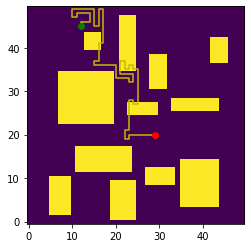

Number of steps taken in pred Path 101


In [98]:
# Test
pred_len = []
astar_len = []
n_test = 0
while n_test < 1:
    # TODO: Generalize to any map shape
    start = (random.randint(1,49), random.randint(1,49))
    goal = (random.randint(1,49), random.randint(1,49))
    arr, test_MAP = placeRandomRooms(map_size, minRoomSize=3, maxRoomSize=15, roomStep = 1, margin = 1, attempts = 100)
    # If path is available, get test info
    try:
        pred_path = test_on_new_map(test_MAP, arr, start, goal, clf)
        OccupancyGridMap(arr, 1).plot()
        plot_path(pred_path)
        pred_len.append(len(pred_path))
        print('Number of steps taken in pred Path', len(pred_path))
        astar_len.append(len(get_path(start, goal, arr, False)))
        n_test += 1
    except:
        # No path found
        continue

In [245]:
def plot_path_with_lines(pred_path, MAP):
    '''
    Given predicted path nodes and map, 
    plot the path and the sensor readings for each node
    '''
    # Update node positions for shapely plotting
    pred_path = [(p[0]+0.5, p[1]+0.5) for p in pred_path]
    # Save filenames for GIF creation
    filenames=[]
    for i, node in enumerate(pred_path):
        # Create fig
        fig = plt.figure(frameon=False)
        fig.set_size_inches(6,6)
        plt.plot(*LineString(pred_path).xy)
        plt.scatter(*node, s=30, alpha=1.0)
        # Get lines from sensor 
        _, lines = synthetic_sensor(MAP, node)
        for index, l in enumerate(MAP): 
            if index != 0:
                plt.fill(*l.xy, alpha=1)
            else:
                plt.plot(*l.xy, alpha=1)
        for k, line in enumerate(lines):
            plt.plot(*line.xy, alpha=0.25)
        filenames.append('img_{}.png'.format(i))
        plt.savefig('img_{}.png'.format(i))
        plt.close()
    
    # Make GIF
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('demo.gif', images)
        
plot_path_with_lines(pred_path, test_MAP)

In [244]:
# DL Solution ... not currently learning. 

import torch
class SensorData(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df.copy()
        self.mms = MinMaxScaler()
        self.mms.fit(df.drop('out', axis=1).values)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        x = self.mms.transform(sample.drop('out').values.astype(np.float32).reshape(1,-1))
        y = sample['out']
        return (torch.from_numpy(x).double(), y)
    
ds = SensorData(df)
train_loader = torch.utils.data.DataLoader(ds,64,True, num_workers=0, pin_memory=True)

from resnet1d import ResNet1D
model = ResNet1D(1,64,3,3,1,24,4).cuda()

from tqdm.notebook import tqdm
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

loss = 0
for i in range(20):
    ep_loss = 0
    for batch in tqdm(train_loader):
        model.train()
        x,y = batch[0].cuda().float(), batch[1].cuda()

        optimizer.zero_grad()
        
        out = model(x)
        loss = criterion(out,y.long())
        loss.backward()
        optimizer.step()
        ep_loss += loss.item()
        
    print(ep_loss/len(train_loader))
        

NameError: name 'nn' is not defined